<a href="https://colab.research.google.com/github/nour2003-coder/insect_classification/blob/main/butterfly_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/butterfly-images40-species")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'butterfly-images40-species' dataset.
Path to dataset files: /kaggle/input/butterfly-images40-species


In [ ]:
import os
print(os.listdir(path))

['training.csv.csv', 'butterflies and moths.csv', 'EfficientNetB0-100-(224 X 224)- 97.59.h5', 'valid', 'test', 'train']


In [ ]:
csv_path = os.path.join(path, "butterflies and moths.csv")

### 1)set up the environment

In [ ]:
!pip install tensorflow

In [ ]:
## Remove Warnings ##
import warnings
warnings.filterwarnings("ignore")

## Data ##
import numpy as np
import pandas as pd
import os

## Visualization ##
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go

## Image ##
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Tensorflow ##
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam , RMSprop
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau , EarlyStopping , ModelCheckpoint , LearningRateScheduler
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU device name:", tf.test.gpu_device_name())


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Built with CUDA: True
GPU device name: /device:GPU:0


### 2) Load Data

In [ ]:
df=pd.read_csv(csv_path)
df.head()

,class id,filepaths,labels,data set
0,0,train/ADONIS/001.jpg,ADONIS,train
1,0,train/ADONIS/002.jpg,ADONIS,train
2,0,train/ADONIS/003.jpg,ADONIS,train
3,0,train/ADONIS/004.jpg,ADONIS,train
4,0,train/ADONIS/005.jpg,ADONIS,train


In [ ]:
IMAGE_DIR = path

In [ ]:
df['filepaths']=IMAGE_DIR+'/'+df['filepaths']
df.head()

,class id,filepaths,labels,data set
0,0,/kaggle/input/butterfly-images40-species/train...,ADONIS,train
1,0,/kaggle/input/butterfly-images40-species/train...,ADONIS,train
2,0,/kaggle/input/butterfly-images40-species/train...,ADONIS,train
3,0,/kaggle/input/butterfly-images40-species/train...,ADONIS,train
4,0,/kaggle/input/butterfly-images40-species/train...,ADONIS,train


In [ ]:
df_train=df.loc[df['data set'] == 'train']
df_test=df.loc[df['data set'] == 'test']
df_val=df.loc[df['data set'] == 'valid']

### 3) Exploratory Data Analysis

In [ ]:
label_counts=df['labels'].value_counts()[:10]
fig=px.bar(x=label_counts.index,y=label_counts.values,color=label_counts.values,text=label_counts.values,color_continuous_scale='Blues')

In [ ]:
fig.update_layout(
    title_text="Top 10 Labels distribution",
    template='plotly_white',
    xaxis=dict(title='Label'),
    yaxis=dict(title='Count')
)
fig.show()

In [ ]:
def show_grid_images(image_path_list,ncols,title,augmentor=None):
  figure,axs=plt.subplots(figsize=(22,4),nrows=1,ncols=ncols)
  for i in range(ncols):
    image=cv2.cvtColor(cv2.imread(image_path_list[i]),cv2.COLOR_BGR2RGB)
    if augmentor is not None:
      image=augmentor(image=image)['image']
    axs[i].imshow(image)
    axs[i].set_title(title)
  plt.show()

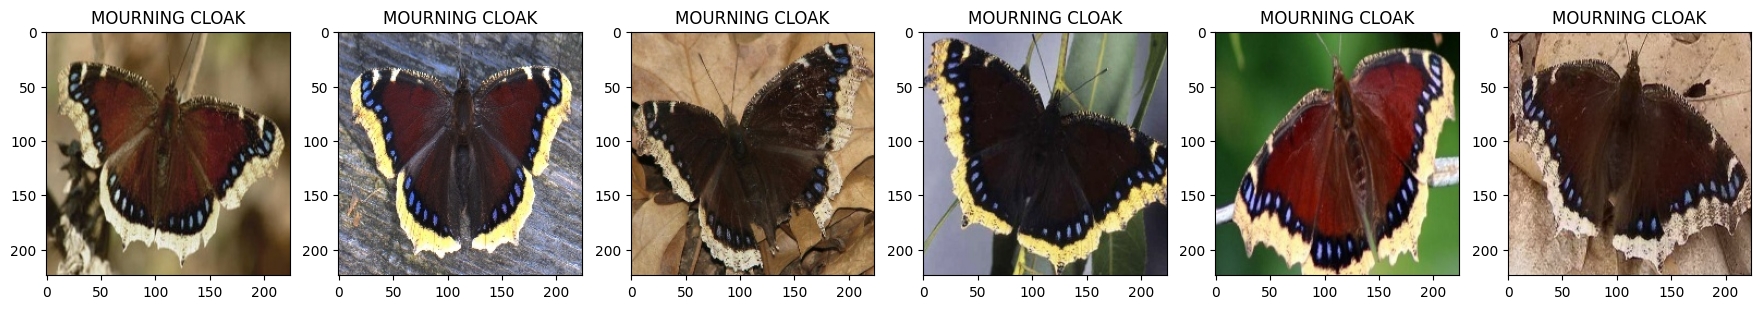

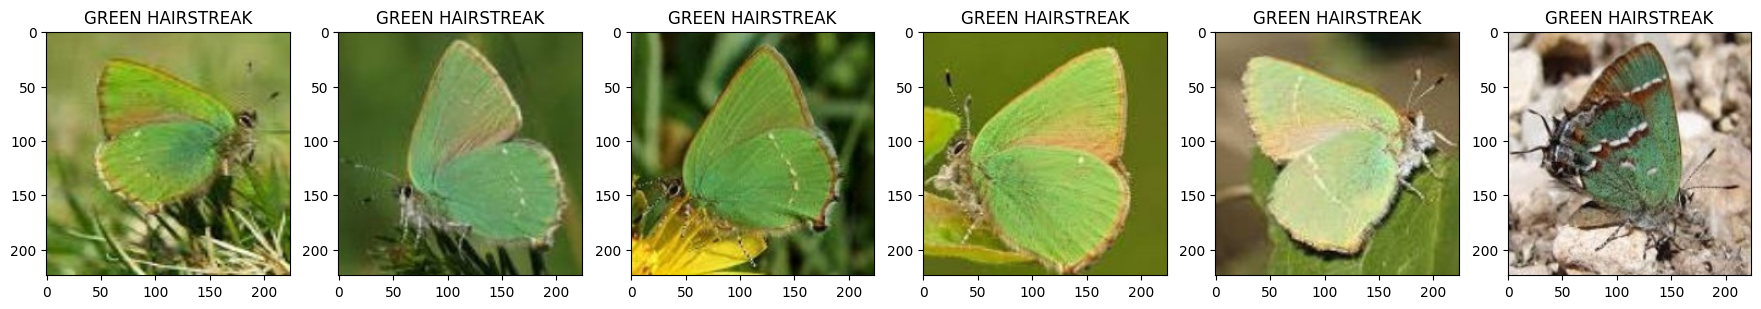

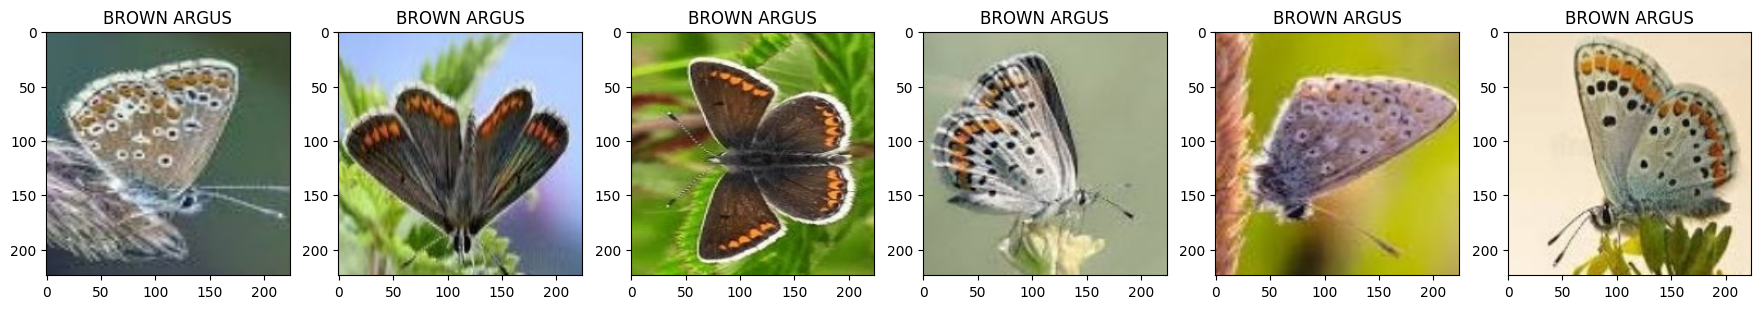

In [ ]:
top3_labels=label_counts[:3].index.tolist()
label1_images=df.loc[df['labels']==top3_labels[0]]['filepaths'].iloc[:6].tolist()
label2_images=df.loc[df['labels'] == top3_labels[1]]['filepaths'].iloc[:6].tolist()
label3_images=df.loc[df['labels'] == top3_labels[2]]['filepaths'].iloc[:6].tolist()
show_grid_images(label1_images,6,top3_labels[0])
show_grid_images(label2_images,6,top3_labels[1])
show_grid_images(label3_images,6,top3_labels[2])

### 4) Data augmentation

In [ ]:
"""
*What is ImageDataGenerator?
  It's a Keras tool that:
  loads images from folders
  applies real-time preprocessing
  applies augmentation (if you want)
  creates batches automatically
"""

"\n*What is ImageDataGenerator?\n  It's a Keras tool that:\n  loads images from folders\n  applies real-time preprocessing\n  applies augmentation (if you want)\n  creates batches automatically\n"

In [ ]:
train_dir = os.path.join(path, "train")
val_dir = os.path.join(path, "valid")

In [ ]:
BATCH_SIZE = 32
SEED = 56
IMAGE_SIZE = (224, 224)

In [ ]:
# class_mode='sparse' Labels will be integer encoded

In [ ]:
train_gen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1/255.)
val_gen = ImageDataGenerator(rescale=1/255.)
train_flow_gen = train_gen.flow_from_directory(directory=train_dir, #where images are stored
                                              class_mode='sparse',
                                              batch_size=BATCH_SIZE,
                                              target_size=IMAGE_SIZE,
                                              seed=SEED)
val_flow_gen = val_gen.flow_from_directory(directory=val_dir,
                                            class_mode='sparse',
                                            batch_size=BATCH_SIZE,
                                            target_size=IMAGE_SIZE,
                                            seed=SEED)

Found 12594 images belonging to 100 classes.
Found 500 images belonging to 100 classes.


In [ ]:
test_dir=os.path.join(path, "test")
test_gen = ImageDataGenerator(rescale=1/255.)
test_flow_gen = test_gen.flow_from_directory(directory=test_dir,
                                             class_mode='sparse',
                                             batch_size=BATCH_SIZE,
                                             target_size=IMAGE_SIZE,
                                             seed=SEED)

Found 500 images belonging to 100 classes.


### 5) Create models

In [ ]:
def create_model(model_name,verbose=False):
  input_tensor= Input(shape=(224,224,3))
  if model_name == 'resnet50':
    base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
  elif model_name == 'xception':
    base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
  bm_output=base_model.output

  x=GlobalAveragePooling2D()(bm_output)
  x=Dense(1024,activation='relu')(x)
  x=Dropout(rate=0.5)(x)
  output=Dense(100,activation='softmax')(x)
  model=Model(inputs=input_tensor,outputs=output)
  if verbose:
    model.summary()
  return model

In [ ]:
resnet_model = create_model(model_name='resnet50', verbose=False)
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, mode='min', verbose=0)
early_cb = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=0)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
resnet_model.fit(train_flow_gen, epochs=15,
         steps_per_epoch=int(np.ceil(df_train.shape[0]/BATCH_SIZE)),
         validation_data=val_flow_gen,
         validation_steps=int(np.ceil(df_val.shape[0]/BATCH_SIZE)),
         callbacks=[rlr_cb, early_cb])

Epoch 1/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 194s 343ms/step - accuracy: 0.1489 - loss: 3.7598 - val_accuracy: 0.1520 - val_loss: 5.6047 - learning_rate: 0.0010
Epoch 2/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 100s 252ms/step - accuracy: 0.5835 - loss: 1.4381 - val_accuracy: 0.6460 - val_loss: 1.5086 - learning_rate: 0.0010
Epoch 3/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 103s 260ms/step - accuracy: 0.7380 - loss: 0.8967 - val_accuracy: 0.7260 - val_loss: 0.9351 - learning_rate: 0.0010
Epoch 4/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 100s 253ms/step - accuracy: 0.7916 - loss: 0.6927 - val_accuracy: 0.8100 - val_loss: 0.6836 - learning_rate: 0.0010
Epoch 5/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 99s 251ms/step - accuracy: 0.8297 - loss: 0.5873 - val_accuracy: 0.8100 - val_loss: 0.6757 - learning_rate: 0.0010
Epoch 6/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 99s 252ms/step - accuracy: 0.8570 - loss: 0.4809 - val_accuracy: 0.7880 - val_loss: 0.7990 - learning_rate: 0.0010
Epoch 7/15
394/394 ━━━━━━━━━━━━━━━━━━━━ 99s 252ms/step - accuracy:

In [ ]:
print('ResNet Test Data Accuracy: {0}'.format(resnet_model.evaluate(test_flow_gen)[1:][0]))

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9619 - loss: 0.2007
ResNet Test Data Accuracy: 0.9660000205039978


In [ ]:
resnet_model.save("resnet_model.keras")

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

img_path = "/content/005.jpg"

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)


In [ ]:
pred = resnet_model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


In [ ]:
class_names = list(train_flow_gen.class_indices.keys())
print(class_names)

['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BANDED TIGER MOTH', 'BECKERS WHITE', 'BIRD CHERRY ERMINE MOTH', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CINNABAR MOTH', 'CLEARWING MOTH', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMET MOTH', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'EMPEROR GUM MOTH', 'GARDEN TIGER MOTH', 'GIANT LEOPARD MOTH', 'GLITTERING SAPPHIRE', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREEN HAIRSTREAK', 'GREY HAIRSTREAK', 'HERCULES MOTH', 'HUMMING BIRD HAWK MOTH', 'INDRA SWALLOW', 'IO MOTH', 'Iphiclus si

In [ ]:
print("Predicted class:", class_names[pred_class])

Predicted class: BLUE MORPHO


In [ ]:
#https://www.pinecone.io/learn/series/image-search/cnn/

In [ ]:
#https://www.pinecone.io/learn/softmax-activation/